# Performance of CPU and GPU material integration

This short demo reports the computational performance that can be expected when running `jaxmat` on a CPU or GPU for a batch of $N$ material points.$\newcommand{\bFe}{\boldsymbol{F}^\text{e}}\newcommand{\bFp}{\boldsymbol{F}^\text{p}}\newcommand{\bbe}{\boldsymbol{b}^\text{e}}\newcommand{\bbebar}{\overline{\boldsymbol{b}}^\text{e}}$

The behavior is a finite-strain $\bF^\text{e}\bF^\text{p}$ elastoplastic model implemented in the `FeFpJ2Plasticity` behavior. We perform a monotonic strain-driven constitutive integration for 20 steps for $\epsilon=0$ to $5.10^{-2}$ for an isochoric tension:

$$
\bF = \diag(1+\epsilon, 1/\sqrt{1+\epsilon}, 1/\sqrt{1+\epsilon})
$$

## Material model

We briefly describe the equations of the `FeFpJ2Plasticity` model. More details can be found in {cite:p}`seidl2022calibration`.

### Evolution equations

As stated before, the model is based on a $\bFe\bFp$ split of the total deformation gradient $\bF$. The plastic deformation is assumed to be isochoric so that $J=\det\bF=\det\bFe$. The elastic response is assumed to be hyperelastic and is expressed in terms of the Kirchhoff stress $\btau$ and its deviatoric part $\bs=\dev(\btau)$ as follows:

$$
\begin{align}
\btau &= \bs + \dfrac{\kappa}{2}(J^2-1)\bI\\
\bs &= \mu\dev{\bbebar}
\end{align}
$$
where $\bbebar = J^{-2/3}\bbe$ with $\bbe=\bFe{\bFe}^\text{T}$ being the elastic left Cauchy-Green strain tensor.

For the plastic part, we assume a von Mises-type $J_2$ plasticity with the following yield function:

$$
f(\btau;p) = \sqrt{\dfrac{3}{2}}\|\bs\| - R(p)
$$
where $p$ is the cumulated plastic strain and $R(p)$ a user-defined yield stress.

The evolution of $p$ is given by the associated plastic flow rule, while the isotropic part evolution is given by the isochoric plastic condition $\det(\bbe)=J^2$.

### Discrete evolutions equations

Discretization of the above evolution equations follows a procedure similar to the integration of small-strain elastoplastic models. In particular, we use the Fischer-Burmeister approach to enforce plastic consistency conditions.

In our implementation, internal state variables are the cumulated plastic strain $p$ and the volume preserving elastic strain $\bbebar$. The latter is initialized with the identity tensor to specify a natural unstressed elastic configuration.

We first compute an elastic stress predictor based on the relative deformation gradient given by:

$$
\begin{align}
\boldsymbol{f}_{n+1} &= \bF_{n+1}(\bF_n)^{-1}\\
\bar{\boldsymbol{f}}_{n+1} &= \det(\boldsymbol{f}_{n+1})^{-1/3}\boldsymbol{f}_{n+1}
\end{align}
$$
where $\bF_n$ is the previous deformation gradient and $\bF_{n+1}$ the current one.

Assuming an elastic evolution at first, the trial elastic strain is given by:

$$
\bbebar_\text{trial} = \bar{\boldsymbol{f}}_{n+1}^\text{T}\bbebar_n\bar{\boldsymbol{f}}_{n+1}
$$

For the new elastic strain $\bbebar$, the deviatoric stress is $\bs = \mu\dev(\bbebar)$.

The yield condition is then given by:
$$
f(\bs) = \sqrt{\dfrac{3}{2}} \|\bs\| - R(p_n+\Delta p)
$$

The plastic consistency conditions are then encoded using the Fischer-Burmeister function $\text{FB}$ as:

$$
r_p = \text{FB}(-f(\bs),\Delta p) = 0
$$

Finally, the remaining discrete evolution equations are given following {cite:p}`seidl2022calibration` as:

$$
r_{\bbe} = \dev(\bbebar - \bbebar_\text{trial})  + \sqrt{\dfrac{2}{3}}\Delta p \operatorname{tr}(\bbebar) \dfrac{\bs}{\|\bs\|}   + \bI (\det(\bbebar) - 1) = 0
$$

Note that the first part of $r_{\bbe}$ is deviatoric only and enforce the plastic flow rule whereas the last term is purely spherical and enforces the plastic incompressibility condition.
The nonlinear Newton system $(r_p,r_{\bbe})$ is then solved using `optimistix` for $\Delta p$ and $\bbebar$.

Finally, the first Piola-Kirchhoff stress is obtained from the Kirchhoff stress as follows:

$$
\bP = \btau\bF^{-\text{T}}
$$

The tangent operator is again computed using AD which avoids us to compute explicitly the consistent tangent operator which is particularly nasty for such $\bFe\bFp$ models.

## Performance timing

The constitutive integration is done for a batch of $N$ material points using `vmap` and is jitted. We also possibly compute the consistent tangent operator (case `jac`), otherwise only stress and state are computed without tangent operator (case `no_jac`). Computations are done in the {download}`generate_performance_data.py` script.

Timing for integrating the whole batch is reported for each increment. Timing varies with increment number due to elastic vs. plastic regime but material parameters and loading amplitude are chosen to yield substantial plastic evolution. Note that a dummy integration is launched first to remove JIT compilation overhead from the reported timings.

We report below the average timing per increment for the whole batch as a function of $N$. Simulations are run on a *Intel Core i7-12700H* (`"CPU"`) or on a single *NVIDIA RTX A1000 Laptop GPU* (`"GPU"`).

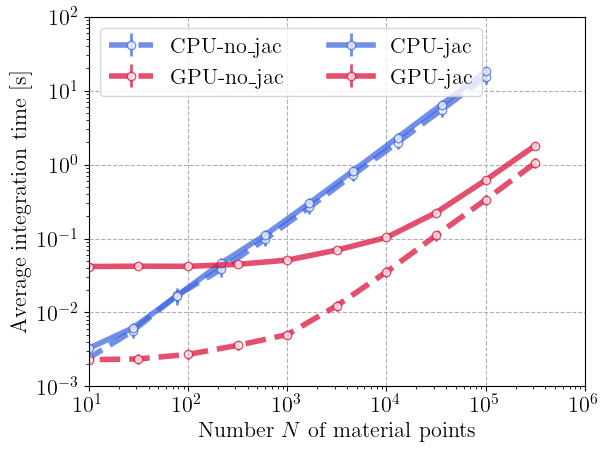

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from jaxmat import get_path

current_path = get_path()
data = np.loadtxt(
    current_path / "../demos/_data/Treloar_rubber.csv", skiprows=1, delimiter=","
)

colors = {"cpu": "royalblue", "gpu": "crimson"}
style = {"jac": "-", "no_jac": "--"}

for jac in ["no_jac", "jac"]:
    for platform in ["cpu", "gpu"]:
        data = np.loadtxt(
            current_path / "../demos/_data" / f"performance_{jac}_{platform}.csv",
            delimiter=",",
        )
        Nbatch_list = data[:, 0]
        times = data[:, 1:]
        plt.errorbar(
            Nbatch_list,
            np.mean(times, axis=1),
            np.std(times, axis=1),
            fmt=f"o{style[jac]}",
            markerfacecolor="white",
            color=colors[platform],
            label=platform.upper() + "-" + jac,
            linewidth=4.0,
            alpha=0.75,
            elinewidth=2.0,
        )
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.xlabel(r"Number $N$ of material points")
plt.ylabel("Average integration time [s]")
plt.legend(ncol=2)
plt.show()

We can clearly see a linear scaling in all cases with the batch size $N$. For large-scale problems, the GPU achieves a speedup of one to two orders of magnitude (10x--100x) compared to the CPU. At small batch sizes, the GPU curves remain nearly flat, indicating that the total computation time is dominated by kernel launch and data transfer overheads. In this regime, the GPU is underutilized. Once the workload becomes large enough to saturate the device, the computation time grows linearly, reflecting efficient parallel scaling and full hardware utilization.
Finally, because of the smaller cost on GPU the jacobian overhead is more visible on the GPU log-log plots than for the CPU.

## References

```{bibliography}
:filter: docname in docnames
```